In [1]:
import os
import sys
import numpy as np
import ROOT as r
import matplotlib.pyplot as plt
import hist
import matplotlib
import uproot
from scipy.interpolate import interp1d
from nearline_helpers import *

Welcome to JupyROOT 6.26/10


In [2]:
# f = r.TFile("~/nearline_hists_run00207_00000.root")
# f = r.TFile("../bin/run00207_00000.mid.root")
infiles = [
    # "../bin/run00233_00000.mid.root",
    # "../bin/run00237_*.mid.root",
    # "../bin/run00238_*.mid.root",
    # "../bin/run00243_00000.mid.root",
    # '../plotting/data/nearline_hists_run00234_00000.root',
    # '../plotting/data/nearline_hists_run00234_00001.root',
    "../bin/*run00270_*.root",
]

In [3]:
# t = f.Get("tree")
t = r.TChain('tree')
for x in infiles:
    t.Add(x)

In [4]:
t.GetEntries()

298871

In [5]:
t.GetEntry(0)
wf = t.waveforms[0]
nsamples = wf.trace.size()
print(f'{nsamples=}')

nsamples=800


In [6]:
channel_axis = hist.axis.IntCategory(range(5),label='channel')
amc_axis = hist.axis.IntCategory(range(1,3),label='amc')
sample_axis = hist.axis.Regular(nsamples,-nsamples//2-0.5,nsamples//2-0.5,label='Samples')
normalized_energy_axis = hist.axis.Regular(220,-1.1,1.1,label='Energy')
amplitude_axis = hist.axis.Regular(10,0,1000,label='Pulse Amplitude [ADC counts]')
h = hist.Hist(
    channel_axis,
    amc_axis,
    sample_axis,
    normalized_energy_axis,
    amplitude_axis
)

In [10]:
counter = 0
h.reset()
for i, e in enumerate(t):
    for j, wf in enumerate(e.integrals):
        if(wf.integral > 1e3):
            trace = np.array(wf.raw.GetObject().trace)        
            max_sample = np.amax(trace)
            max_index = list(trace).index(max_sample)
            ped = np.average(trace[max_index-50:max_index-25])
            if (np.abs(max_sample - ped) < 50):
                continue
            if(max_index < nsamples//4 or max_index > nsamples-nsamples//4 or max_sample >= 2000):
                continue
            
            peak_time = np.average(range(max_index-3,max_index+4), weights=trace[max_index-3:max_index+4])
            # samples = np.arange(len(trace)) - max_index
            samples = np.arange(len(trace)) - peak_time
            amp = (trace-ped)/(max_sample-ped)
            energy = wf.amplitude
            h.fill(wf.channelTag, wf.amcNum, samples, amp, energy)
            # print(peak_time,max_index)
            # plt.plot(samples,amp)
            # plt.show()
    #         counter += 1
    #         if(counter > 1):
    #             break
    # if (counter > 1):
    #     break

/home/jlab/miniconda3/envs/gm2_11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/jlab/miniconda3/envs/gm2_11/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200.0, 300.0)


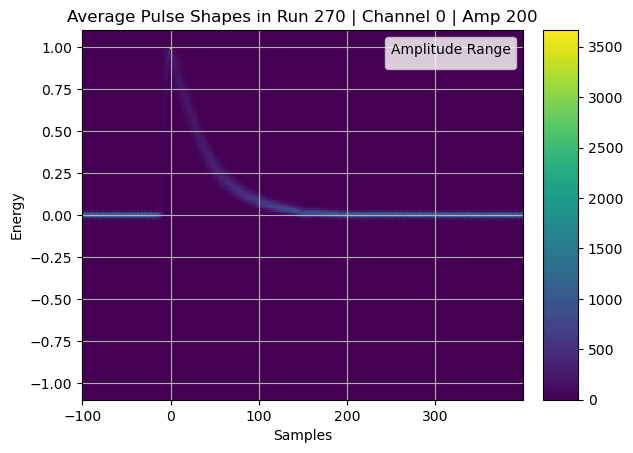

In [12]:
channel = 0
amc = 1
amplitudes = [200,400,600,800]
for amp in amplitudes:
    bini = h.axes[-1][h.axes[-1].index(amp)]
    print(bini)
    hi = h[hist.loc(channel),hist.loc(amc),:,:,hist.loc(amp)][-100j:,:]
    hi.plot()
# h[hist.loc(channel),hist.loc(amc),:,:,500j].profile(1).plot(yerr=False)
# h[hist.loc(channel),hist.loc(amc),:,:,800j].profile(1).plot(yerr=False)
    plt.grid()
    plt.legend(title = 'Amplitude Range')
    plt.title(f'Average Pulse Shapes in Run 270 | Channel {channel} | Amp {amp}')
    plt.show()
    break

(200.0, 300.0)
(400.0, 500.0)
(600.0, 700.0)
(800.0, 900.0)


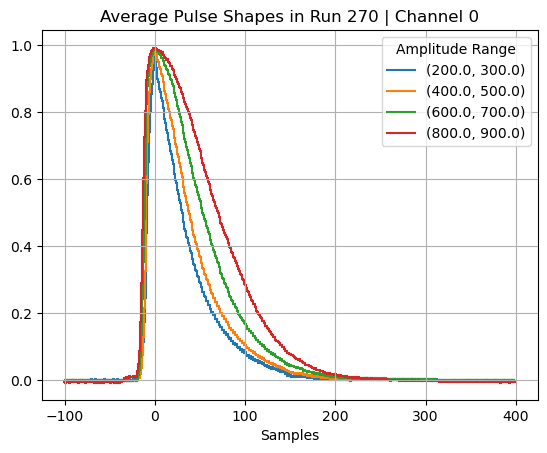

In [13]:
channel = 0
amc = 1
amplitudes = [200,400,600,800]
for amp in amplitudes:
    bini = h.axes[-1][h.axes[-1].index(amp)]
    print(bini)
    hi = h[hist.loc(channel),hist.loc(amc),:,:,hist.loc(amp)].profile(1)[-100j:]
    hi.plot(yerr=False,label=f'{bini}')
# h[hist.loc(channel),hist.loc(amc),:,:,500j].profile(1).plot(yerr=False)
# h[hist.loc(channel),hist.loc(amc),:,:,800j].profile(1).plot(yerr=False)
plt.grid()
plt.legend(title = 'Amplitude Range')
plt.title(f'Average Pulse Shapes in Run 270 | Channel {channel}')
plt.show()

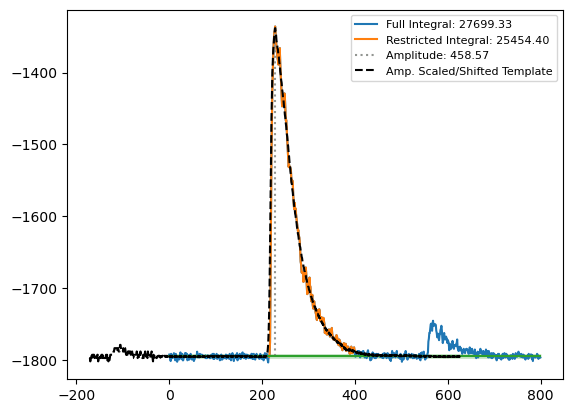

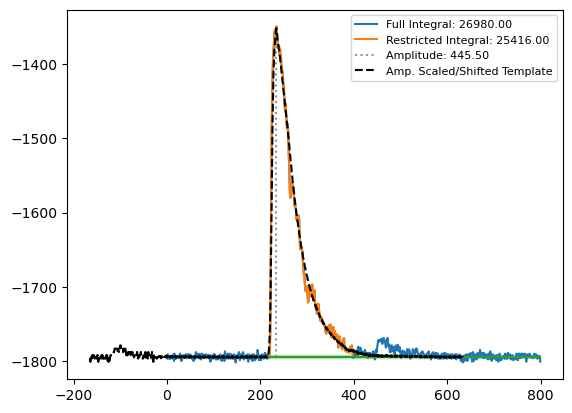

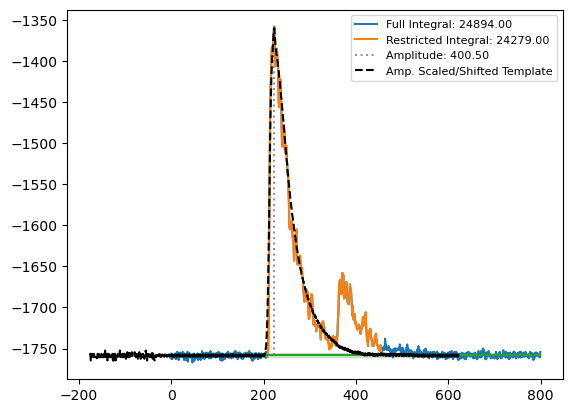

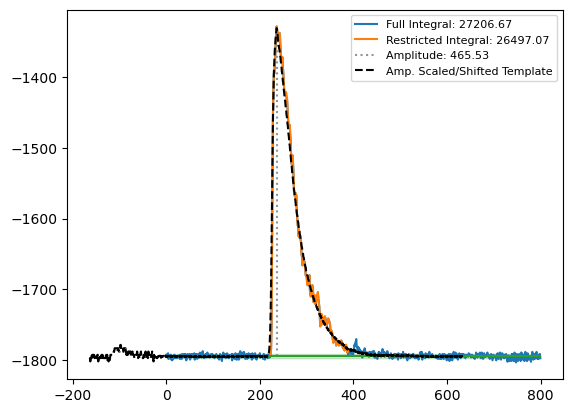

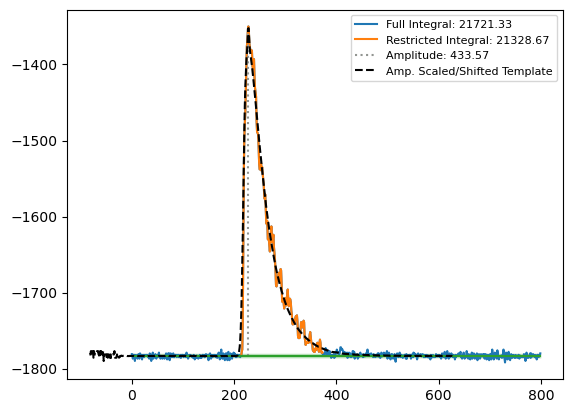

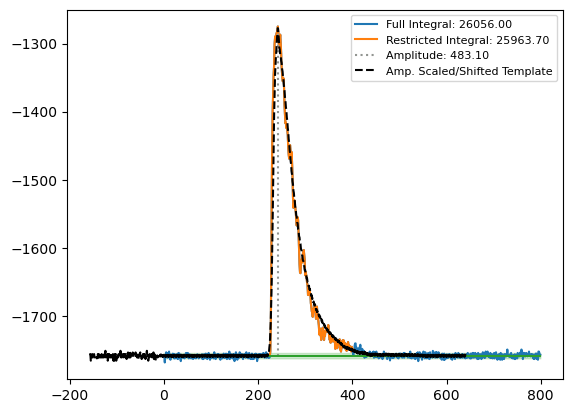

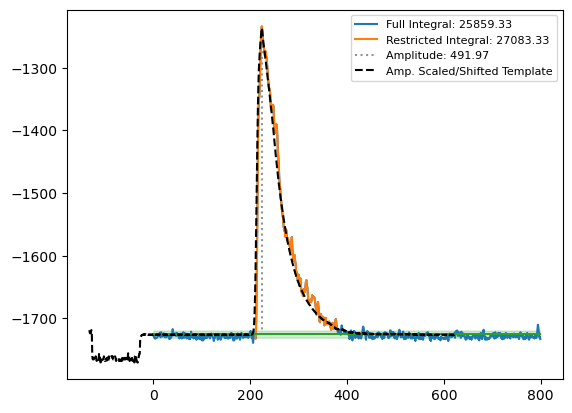

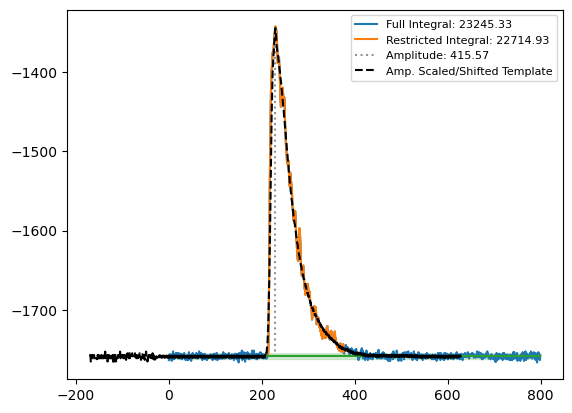

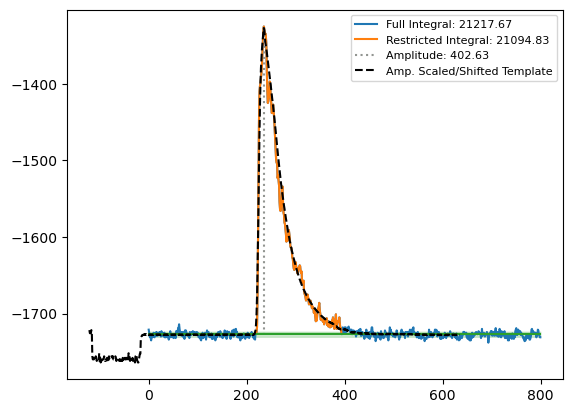

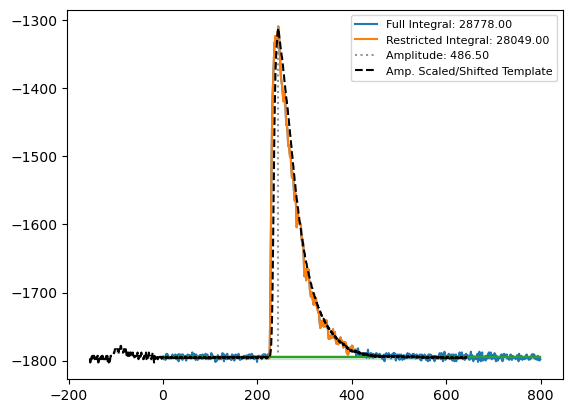

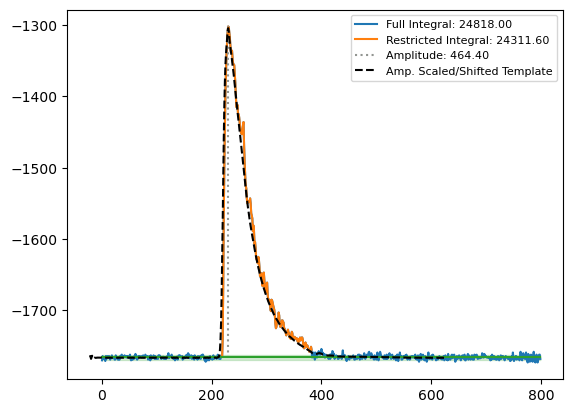

In [46]:
counter = 0
for i, e in enumerate(t):
    for wfi in e.integrals:
        # if wfi.amplitude < 800 or wfi.amplitude > 900:
        if wfi.amplitude < 400 or wfi.amplitude > 500:
            continue
        amp = wfi.amplitude
        channel = wfi.channelTag
        amc = wfi.amcNum
        trace = wfi.raw.GetObject().trace
        hi = h[hist.loc(channel),hist.loc(amc),:,:,hist.loc(amp)].profile(1)
        # hi = h[hist.loc(channel),hist.loc(amc),:,:,hist.loc(200)].profile(1)
        peak_time = list(trace).index(np.amax(trace))
        xs = hi.axes[0].centers + peak_time
        ys = wfi.amplitude*hi.values() + wfi.pedestalLevel
        fig,ax = plot_integral(wfi)
        # hi.plot(ax=ax)
        plt.plot(xs,ys, "--", color='black',label='Amp. Scaled/Shifted Template')
        plt.legend(fontsize=8)
        plt.show()
        counter += 1
    if(counter > 10):
        break
        # break
    # if( i > 2):
    #     break

In [27]:
from g2fit.fitting import PyFit

In [28]:
hi.values().shape, hi.axes[0].centers.shape

((800,), (800,))

In [29]:
plt.plot(expo_diff(hi.axes[0].centers, guess))

NameError: name 'expo_diff' is not defined

In [ ]:
hi.axes[0].centers.shape, expo_diff(hi.axes[0].centers, guess).shape

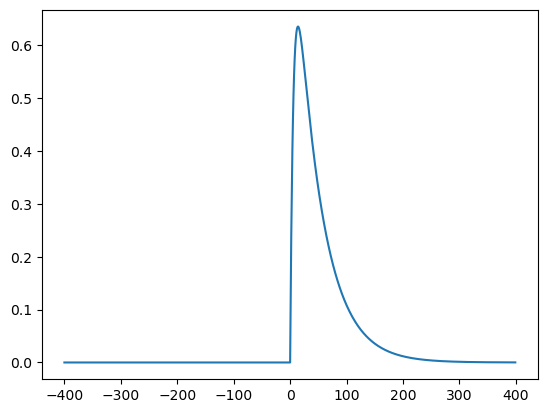

In [30]:
def expo_diff(x,p):
    ys1 = np.exp((p[1]-x)/p[2])
    ys2 = np.exp((p[1]-x)/p[3])
    ding = p[0] * (ys2 - ys1) + p[4]
    return np.where(ding > p[4], ding ,p[4])

guess = [1.0, 0,6,45,0]
plt.plot(hi.axes[0].centers, expo_diff(hi.axes[0].centers, guess))
plt.show()

/home/jlab/github/g2_analysis/submodules/g2fit/fitting.py:222: RuntimeWarning: invalid value encountered in sqrt
  self.xerrs = np.array(xerrs) if (xerrs is not None) else np.sqrt(self.xs)


ERROR: Fit did not converge properly.


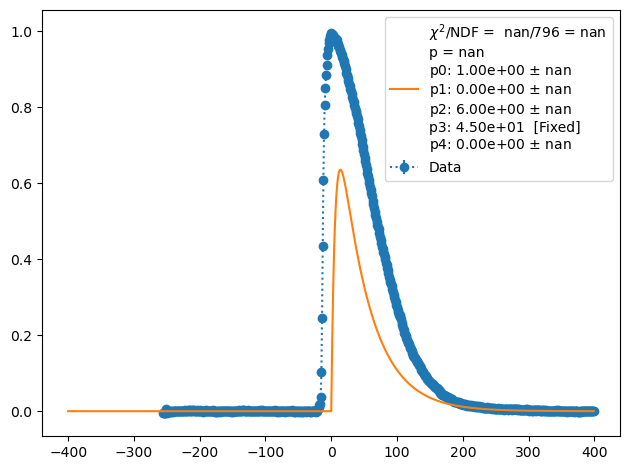

In [31]:

fiti = PyFit(
    hi.axes[0].centers,
    hi.values(),
    expo_diff,
    guess,
    yerrs=np.full_like(hi.values(), 0.01),
    par_limits={
        0:[0,None],
        2:[1,None],
        3:[1,None],
        # 4:[0,None],
    }
)
fiti.m.fixed[3] = 45

fiti.fit()
fiti.simple_plot()
plt.show()

(200.0, 300.0)


/home/jlab/github/g2_analysis/submodules/g2fit/fitting.py:222: RuntimeWarning: invalid value encountered in sqrt
  self.xerrs = np.array(xerrs) if (xerrs is not None) else np.sqrt(self.xs)


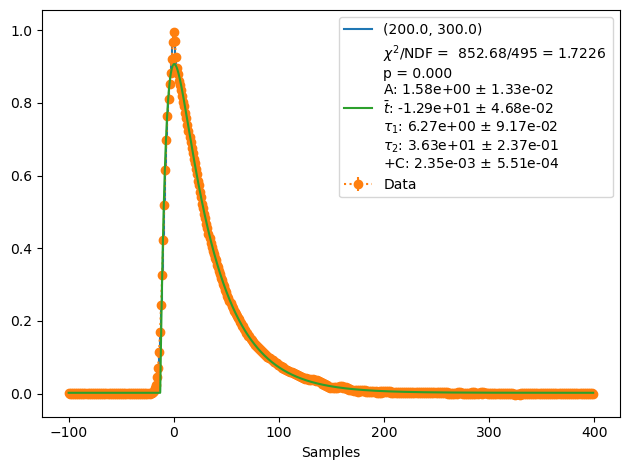

(400.0, 500.0)


/home/jlab/github/g2_analysis/submodules/g2fit/fitting.py:222: RuntimeWarning: invalid value encountered in sqrt
  self.xerrs = np.array(xerrs) if (xerrs is not None) else np.sqrt(self.xs)


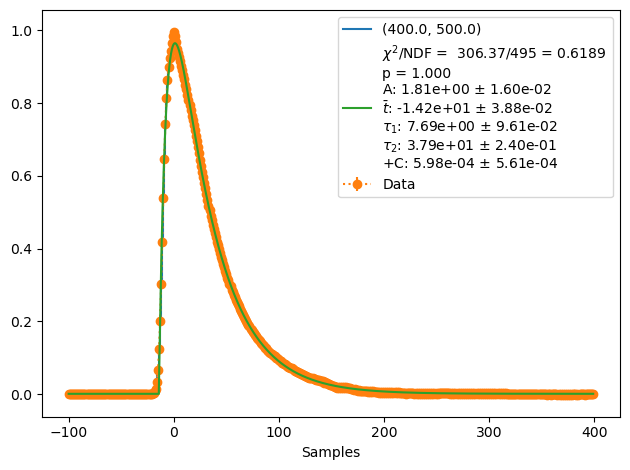

(600.0, 700.0)


/home/jlab/github/g2_analysis/submodules/g2fit/fitting.py:222: RuntimeWarning: invalid value encountered in sqrt
  self.xerrs = np.array(xerrs) if (xerrs is not None) else np.sqrt(self.xs)


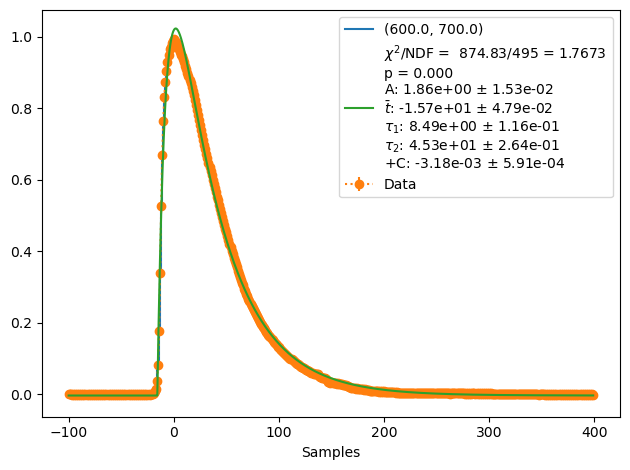

(800.0, 900.0)


/home/jlab/github/g2_analysis/submodules/g2fit/fitting.py:222: RuntimeWarning: invalid value encountered in sqrt
  self.xerrs = np.array(xerrs) if (xerrs is not None) else np.sqrt(self.xs)


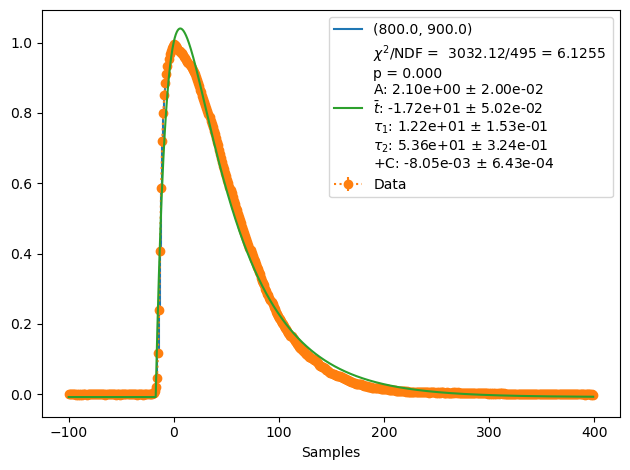

In [33]:
fits = {}
for amp in amplitudes:
    bini = h.axes[-1][h.axes[-1].index(amp)]
    print(bini)
    hi = h[hist.loc(channel),hist.loc(amc),:,:,hist.loc(amp)].profile(1)[-100j:]
    fig,ax = plt.subplots()
    hi.plot(yerr=False,label=f'{bini}')

    
    fiti = PyFit(
        hi.axes[0].centers,
        hi.values(),
        expo_diff,
        guess,
        yerrs=np.full_like(hi.values(), 0.01),
        par_limits={
            0:[0,None],
            2:[1,None],
            3:[1,None],
            # 4:[0,None],
        },
        names=['A', '$\\bar{t}$', "$\\tau_1$", '$\\tau_2$', '+C']
    )
    # fiti.m.fixed[3] = 45

    fiti.fit()
    fiti.simple_plot(ax=ax)
    fits[amp] = fiti
    plt.show()

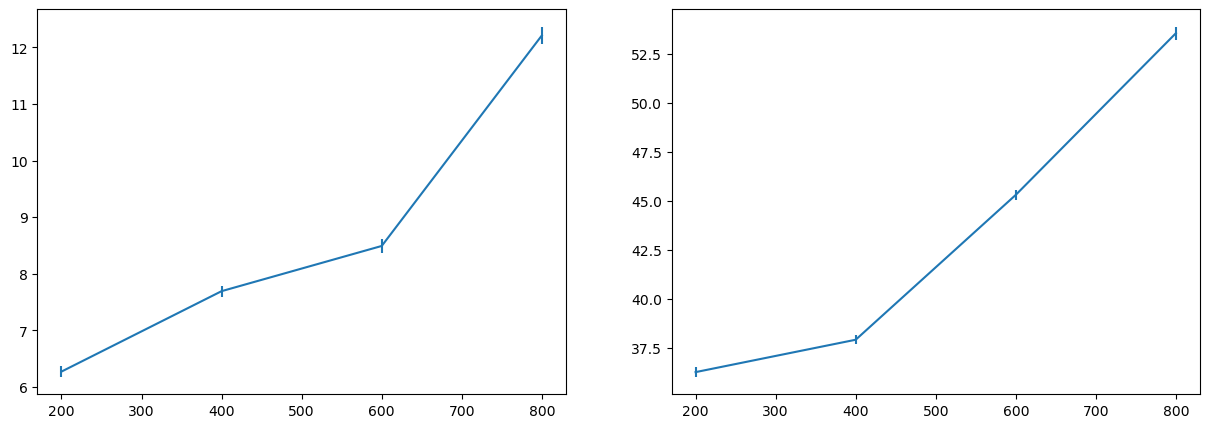

In [37]:
amps = [x for x in fits]
t1s = [fits[x].m.values['$\\tau_1$'] for x in amps]
t2s = [fits[x].m.values['$\\tau_2$'] for x in amps]
t1_errs = [fits[x].m.errors['$\\tau_1$'] for x in amps]
t2_errs = [fits[x].m.errors['$\\tau_2$'] for x in amps]

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].errorbar(amps,t1s, t1_errs)
ax[1].errorbar(amps,t2s, t2_errs)
plt.show()

In [ ]:
from g2fit.functions import logistic_growth, expo

func1 = logistic_growth(xs, g1)
func2 = expo(xs, g2)
plt.plot(xs,func1)
plt.plot(xs,func2)
plt.plot(xs,func1*func2)

In [ ]:
h[::sum,::sum,:,:].plot(
    norm=matplotlib.colors.LogNorm(vmin=1)
)
h[::sum,::sum,:,:].profile(1).plot(
    color='r'
)

In [ ]:
h[::sum,::sum,:,:].plot(
    norm=matplotlib.colors.LogNorm(vmin=1)
)
h[::sum,::sum,:,:].profile(1).plot(
    color='r',
    yerr=False
)
plt.xlim(-100,300)
plt.show()

In [ ]:
h2 = h[::sum,::sum,:,:]
h2.plot()
h2.profile(1).plot(color='r')
plt.show()

In [ ]:
h2 = h[0j,1j,:,:]
h2.plot(norm=matplotlib.colors.LogNorm(vmin=1))
h2.profile(1).plot(color='r')
plt.xlim(-10,10)
plt.show()

In [ ]:
hi = h2.profile(1)
hi.plot(yerr=False)

In [ ]:
hi.plot(yerr=False)
plt.ylim(-0.1,0.1)
plt.xlim(-100,1000)

In [ ]:
samples = hi.axes[0].centers[1:-1]
values = hi.values()[1:-1]
interp = interp1d(samples,values,'cubic', bounds_error=False, fill_value=(values[0], values[-1]))
xs = np.linspace(-1000,1000,2000)
plt.plot(xs,interp(xs))

In [ ]:
samples, hi.values()

In [ ]:
gr = r.TGraph(hi.axes[0].size)
for i, xi in enumerate(hi.axes[0].centers):
    gr.SetPoint(i, xi, hi.values()[i])
c = r.TCanvas()
gr.Draw("apl")
c.Draw()

In [ ]:
spline = r.TSpline3("example",gr)
spline.Draw("")
c.Draw()

---

In [ ]:
outfile = 'new_splines.root'
fout = r.TFile(outfile,'RECREATE')
xs = np.linspace(-1000,1000,2000)
for amc in amc_axis:
    for channel in channel_axis:
        print(channel, amc)
        # if (amc != 2):
        #     continue
        hi = h[hist.loc(channel),hist.loc(amc),:,:].profile(1)
        samples = hi.axes[0].centers[1:-1]
        values = hi.values()[1:-1]
        interp = interp1d(samples,values,'cubic', bounds_error=False, fill_value=(values[0], values[-1]))
        # hi = h[4j,1j,:,:].profile(1) #temporary hack, use one channel (best) for all
        plt.plot(xs,interp(xs))
        plt.plot(samples,values)
        hi.plot(yerr=False)
        plt.title(f'AMC {amc} | Channel {channel}')
        plt.show()
        gr = r.TGraph(xs.size)
        for i, xi in enumerate(xs):
            val = interp(xi)
            gr.SetPoint(i, xi, val)
        gr.Write(f'graph_{amc}_{channel}')
        c = r.TCanvas()
        # gr.Draw("apl")
        # c.Draw()  
        title = f"spline_{amc}_{channel}"
        spline = r.TSpline3(title,gr)
        spline.Write(title)
fout.Write()
fout.Close()

---

In [ ]:
fin = r.TFile('./splines.root')

In [ ]:
sp = fin.Get("spline_1_2")
c = r.TCanvas()
sp.Draw()
c.Draw()